In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Parameters for matplotlib
font = {'size'   : 10, "weight":"normal"}
plt.rc('font', **font)

In [180]:
df=pd.read_csv("detailed_commits_all.csv")

In [181]:
# Commits is cumulative number of commits, i.e. pre-and post publication
df["commits"]=df["commit_after_publication"]+df["commmit_before_publication"]
# Select the most popular repository for each paper
df["popularity"]=df["stars"]+df["forks"]

In [182]:
#Exclude 2020 since there was not enough time to accumulate citations/stars
df=df[~(df["year"]==2020)]

In [183]:
df["citations"].fillna(0,inplace=True)

In [184]:
# For representing time series with no stars
df[((df["stars"]==0) & (df["detailed_stars_week"]=="[]"))]["detailed_stars_week"]="[(0,0)]"

<ipython-input-184-209e91226645>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[((df["stars"]==0) & (df["detailed_stars_week"]=="[]"))]["detailed_stars_week"]="[(0,0)]"


In [185]:
# Only include the most popular repository for a paper.
df.sort_values(by="popularity",ascending=True,inplace=True)
df.drop_duplicates("title",inplace=True)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 100.0)

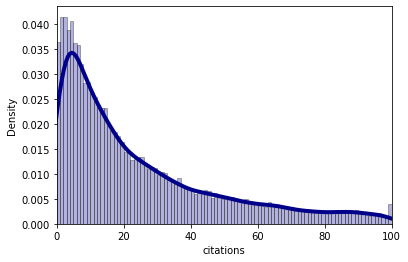

In [186]:
#Citation distribution
import seaborn as sns
filtetred_dict=df[df["citations"]<=100]
ax=sns.distplot(filtetred_dict['citations'], hist=True,kde=True,
             bins=100, color = 'darkblue', 
             hist_kws={"alpha":0.3,'edgecolor':'black'},kde_kws={"color":"darkblue","linewidth":4,"bw_adjust":1})
ax.set_xlim(0,100)

# Preliminary Dataset Visualizations

In [187]:
bar_df=df.groupby(by="year").count()

In [188]:
bar_df["Pp"]=bar_df["citations"]-bar_df["detailed_stars_month"]

In [189]:
bar_df["citations"].sum()

33470

In [190]:
# Total Number of papers with repository
bar_df["detailed_stars_month"].sum()

3724

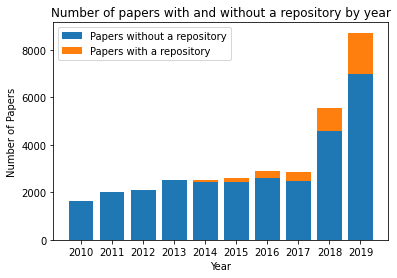

In [155]:
plt.bar(bar_df.index,bar_df["Pp"],label="Papers without a repository")
plt.bar(bar_df.index,bar_df["detailed_stars_month"],label="Papers with a repository",bottom=bar_df["Pp"])
plt.xticks([a for a in range(2010,2020)])
plt.ylabel("Number of Papers")
plt.xlabel("Year")
plt.title("Number of papers with and without a repository by year")
plt.legend(loc="upper left")

# Number papers by conference

In [191]:
import re
conf_df=df.copy(deep=True)

In [195]:
conf_df.groupby(by="Conf").count()

,Unnamed: 0,title,key,year,authors,author_len,H5Index,ImpactScore,conf_date,citations,...,detailed_stars_week,detailed_stars_month,contributors_count,contributors_variance,languages_length,languages,top_lang,language_variance,commits,popularity
Conf,,,,,,,,,,,,,,,,,,,,,
conf/aaai,1393,1393,1393,1393,1393,1393,1393,1393,1393,1393,...,180,180,177,177,180,169,169,169,180,175
conf/acl,3599,3599,3599,3599,3599,3599,3599,3599,3599,3599,...,490,490,479,479,490,454,454,454,488,477
conf/chi,9828,9828,9828,9828,9827,9828,9828,9828,9828,9828,...,261,261,253,253,261,230,230,230,260,260
conf/cvpr,3211,3211,3211,3211,3211,3211,3211,3211,3211,3211,...,483,483,481,481,483,454,454,454,481,470
conf/emnlp,3289,3289,3289,3289,3289,3289,3289,3289,3289,3289,...,539,539,520,520,539,510,510,510,537,524
conf/icml,3589,3589,3589,3589,3588,3589,3589,3589,3589,3589,...,397,397,388,388,397,386,386,386,394,376
conf/kdd,2571,2571,2571,2571,2571,2571,2571,2571,2571,2571,...,299,299,294,294,299,286,286,286,299,286
conf/nips,5990,5990,5990,5990,5984,5990,5990,5990,5990,5990,...,1075,1075,1049,1049,1075,1053,1053,1053,1074,1028


# Correlations

#### Relationship between existance of repository and citaitons using point biseral correlation and cliff's delta

In [10]:
bin_cor=df.copy(deep=True)

In [11]:
bin_cor["HasGithub"]=~bin_cor["detailed_stars_month"].isna()

In [30]:
from scipy.stats import pointbiserialr
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

##### Point biserial for the entire dataset

In [12]:
pointbiserialr(bin_cor['HasGithub'],bin_cor['citations'])

PointbiserialrResult(correlation=0.007582816285461174, pvalue=0.16509398807463588)

##### Point biserial yearly

In [26]:
def yearly_pb(df,i):
    bin_cor=df[df["year"]==i]
    return pointbiserialr(bin_cor['HasGithub'],bin_cor['citations'])

In [14]:
for i in range(2015,2020):
    print(i)
    print(yearly_pb(bin_cor,i))

2015
PointbiserialrResult(correlation=0.07866095028265783, pvalue=5.89996298747002e-05)
2016
PointbiserialrResult(correlation=0.09038319175425262, pvalue=1.0026174692005184e-06)
2017
PointbiserialrResult(correlation=0.054494791912056924, pvalue=0.003502507342483732)
2018
PointbiserialrResult(correlation=0.03127208985549587, pvalue=0.019718989766470033)
2019
PointbiserialrResult(correlation=0.020466900265849495, pvalue=0.05584536515147001)


##### Mann whitney and Student's t test to reject null hypothesis

In [41]:
for i in range(2015,2020):
    print(i)
    bin_corr=df[df["year"]==i]
    bin_corr["HasGithub"]=~bin_corr["detailed_stars_month"].isna()    
    print(mannwhitneyu(bin_corr[bin_corr['HasGithub']==0]["citations"],bin_corr[bin_corr['HasGithub']==1]["citations"]))

2015
MannwhitneyuResult(statistic=155047.0, pvalue=2.1818078140926211e-13)
2016
MannwhitneyuResult(statistic=329162.0, pvalue=7.810340937033767e-19)
2017
MannwhitneyuResult(statistic=385253.0, pvalue=2.9349500108019175e-29)
2018
MannwhitneyuResult(statistic=2193094.0, pvalue=2.8131587394049685e-15)
2019
MannwhitneyuResult(statistic=6068924.0, pvalue=2.1039075334371094e-30)


<ipython-input-41-1ed5fd314c5f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_corr["HasGithub"]=~bin_corr["detailed_stars_month"].isna()
<ipython-input-41-1ed5fd314c5f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_corr["HasGithub"]=~bin_corr["detailed_stars_month"].isna()
<ipython-input-41-1ed5fd314c5f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [42]:
for i in range(2015,2020):
    print(i)
    bin_corr=df[df["year"]==i]
    bin_corr["HasGithub"]=~bin_corr["detailed_stars_month"].isna()    
    print(ttest_ind(bin_corr[bin_corr['HasGithub']==0]["citations"],bin_corr[bin_corr['HasGithub']==1]["citations"]))

2015
Ttest_indResult(statistic=-5.385302440345619, pvalue=7.872420013178931e-08)
2016
Ttest_indResult(statistic=-4.523015659666264, pvalue=6.334245166427256e-06)
2017
Ttest_indResult(statistic=-2.8104608890816634, pvalue=0.004979894817073314)
2018
Ttest_indResult(statistic=-1.762628628142138, pvalue=0.07801644858557585)
2019
Ttest_indResult(statistic=-1.9276790748897719, pvalue=0.05392620637334383)


<ipython-input-42-d423e2594c69>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_corr["HasGithub"]=~bin_corr["detailed_stars_month"].isna()
<ipython-input-42-d423e2594c69>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_corr["HasGithub"]=~bin_corr["detailed_stars_month"].isna()
<ipython-input-42-d423e2594c69>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [16]:
import dabest

##### Yearly cliff's d

In [12]:
def get_cliff_yearly(df,i):
    bin_cor=df[df["year"]==i]
    test_df=pd.DataFrame({"W_Github":bin_cor[bin_cor['HasGithub']==1]["citations"],"Wo_Github":bin_cor[bin_cor['HasGithub']==0]["citations"]})
    test=dabest.load(test_df,idx=("Wo_Github","W_Github"))
    return test.cliffs_delta

In [13]:
def get_median_yearly(df,i):
    bin_cor=df[df["year"]==i]
    test_df=pd.DataFrame({"W_Github":bin_cor[bin_cor['HasGithub']==1]["citations"],"Wo_Github":bin_cor[bin_cor['HasGithub']==0]["citations"]})
    test=dabest.load(test_df,idx=("Wo_Github","W_Github"))
    return test.median_diff

In [17]:
#Median difference on a yearly basis
for i in range(2011,2020):
    print(i)
    print(get_median_yearly(bin_cor,i))

2011
DABEST v0.3.1
             
Good evening!
The current time is Tue Apr 19 22:51:50 2022.

The unpaired median difference between Wo_Github and W_Github is -4.0 [95%CI -34.0, 7.6e+02].
The p-value of the two-sided permutation t-test is 0.857. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.median_diff.statistical_tests`
2012
DABEST v0.3.1
             
Good evening!
The current time is Tue Apr 19 22:51:52 2022.

The unpaired median difference between Wo_Github and W_Github is -16.0 [95%CI -23.0, 1.83e+02].
The p-value of the two-sided permutation t-test is 0.381. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s)

/usr/local/lib/python3.8/dist-packages/dabest/_classes.py:791: UserWarning: The lower limit of the BCa interval cannot be computed. It is set to the effect size itself. All bootstrap values were likely all the same.
  warnings.warn(err_temp.substitute(lim_type="lower"),
/usr/local/lib/python3.8/dist-packages/dabest/_classes.py:796: UserWarning: The upper limit of the BCa interval cannot be computed. It is set to the effect size itself. All bootstrap values were likely all the same.
  warnings.warn(err_temp.substitute(lim_type="upper"),


DABEST v0.3.1
             
Good evening!
The current time is Tue Apr 19 22:52:06 2022.

The unpaired median difference between Wo_Github and W_Github is 25.0 [95%CI 25.0, 25.0].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.median_diff.statistical_tests`
2018
DABEST v0.3.1
             
Good evening!
The current time is Tue Apr 19 22:52:10 2022.

The unpaired median difference between Wo_Github and W_Github is 7.5 [95%CI 5.0, 10.0].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the lik

/usr/local/lib/python3.8/dist-packages/dabest/_classes.py:791: UserWarning: The lower limit of the BCa interval cannot be computed. It is set to the effect size itself. All bootstrap values were likely all the same.
  warnings.warn(err_temp.substitute(lim_type="lower"),
/usr/local/lib/python3.8/dist-packages/dabest/_classes.py:796: UserWarning: The upper limit of the BCa interval cannot be computed. It is set to the effect size itself. All bootstrap values were likely all the same.
  warnings.warn(err_temp.substitute(lim_type="upper"),


DABEST v0.3.1
             
Good evening!
The current time is Tue Apr 19 22:52:16 2022.

The unpaired median difference between Wo_Github and W_Github is 4.0 [95%CI 4.0, 4.0].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.median_diff.statistical_tests`


In [18]:
#Cliff's delta for each year
for i in range(2011,2020):
    print(i)
    print(get_cliff_yearly(bin_cor,i))

2011
DABEST v0.3.1
             
Good evening!
The current time is Tue Apr 19 22:52:31 2022.

The unpaired Cliff's delta between Wo_Github and W_Github is 0.101 [95%CI -0.401, 0.585].
The p-value of the two-sided permutation t-test is 0.616. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cliffs_delta.statistical_tests`
2012
DABEST v0.3.1
             
Good evening!
The current time is Tue Apr 19 22:52:39 2022.

The unpaired Cliff's delta between Wo_Github and W_Github is -0.0142 [95%CI -0.401, 0.484].
The p-value of the two-sided permutation t-test is 0.944. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) report

## Relationship between repository features and citations

In [23]:
feat_corr=df.copy(deep=True)

In [27]:
def get_commits(commits):
    """Returns total number of commits by summing the commit time-series"""
    try:
        if commits:
            if eval(commits):
                commit_dict=eval(commits)
                total=0
                for a,b in commit_dict:
                    total+=b
                return total
            
        else:
            return None
    except:
        return None

In [28]:
feat_corr["commits"]=feat_corr["detailed_commit_day"].apply(get_commits)

In [29]:
#Repository features to relate to with citations
repository_cols=["citations","stars","subscribers","forks","size","OpenIssues","commits","contributors_count","languages_length"]

In [33]:
from scipy.stats import spearmanr,pearsonr
def get_yearly_corr_df(feat_corr,year):
    """Get dataframe of papers with a repository including only the features in the repository columns for a particular year"""
    if type(year)==list:
        df=feat_corr[feat_corr["year"].isin(year)]
    else:
        df=feat_corr[feat_corr["year"]==year]
        
    df=df[~df['detailed_stars_day'].isna()]
    df=df[~(df['detailed_stars_day']=="[]")]
    df=df[repository_cols]
    df.fillna(0,inplace=True)
    return df

In [34]:
#Entire dataset unsegregated by years
feat_df=get_yearly_corr_df(feat_corr,[i for i in range(2010,2020)])

In [35]:
feat_df=get_yearly_corr_df(feat_corr,[i for i in range(2015,2020)])
for col in feat_df.columns:
    print(col)
    print(spearmanr(feat_df[col],feat_df["citations"]))
    print(pearsonr(feat_df[col],feat_df["citations"]))

citations
SpearmanrResult(correlation=1.0, pvalue=0.0)
(0.9999999999999996, 0.0)
stars
SpearmanrResult(correlation=0.4136330567575703, pvalue=2.3295447982730624e-141)
(0.024392779308032256, 0.15399162899312005)
subscribers
SpearmanrResult(correlation=0.2887510600775179, pvalue=1.2997747521356813e-66)
(0.027823898982048668, 0.10391374504755015)
forks
SpearmanrResult(correlation=0.40394452030974176, pvalue=2.693328127931683e-134)
(0.03055933234811503, 0.07408101230610764)
size
SpearmanrResult(correlation=0.02642821306352587, pvalue=0.12245063257938703)
(-0.008082937968798751, 0.6366956300116208)
OpenIssues
SpearmanrResult(correlation=0.23047328602563255, pvalue=1.9750960842020226e-42)
(0.02106715882312069, 0.2182596034287667)
commits
SpearmanrResult(correlation=0.11721682690255011, pvalue=6.281253511477771e-12)
(0.0008342794954890552, 0.9611184765345694)
contributors_count
SpearmanrResult(correlation=0.10330119063981208, pvalue=1.4264083339516542e-09)
(0.020921770814010806, 0.22145406487

In [36]:
year=2015
feat_df=get_yearly_corr_df(feat_corr,year)
for col in feat_df.columns:
    print(col)
    print(spearmanr(feat_df[col],feat_df["citations"]))

citations
SpearmanrResult(correlation=1.0, pvalue=0.0)
stars
SpearmanrResult(correlation=0.36280940118314325, pvalue=1.9399511347697984e-06)
subscribers
SpearmanrResult(correlation=0.21584475402667785, pvalue=0.005653831968408587)
forks
SpearmanrResult(correlation=0.346964398800415, pvalue=5.694761911528637e-06)
size
SpearmanrResult(correlation=-0.1826230468194287, pvalue=0.01963299844414283)
OpenIssues
SpearmanrResult(correlation=0.18927113256193473, pvalue=0.015530385716245657)
commits
SpearmanrResult(correlation=0.04772480191274593, pvalue=0.5452021469392837)
contributors_count
SpearmanrResult(correlation=0.08468131133966253, pvalue=0.2824866623981673)
languages_length
SpearmanrResult(correlation=-0.0029041173561152648, pvalue=0.9706508356505492)


In [37]:
year=2016
feat_df=get_yearly_corr_df(feat_corr,year)
for col in feat_df.columns:
    print(col)
    print(spearmanr(feat_df[col],feat_df["citations"]))


citations
SpearmanrResult(correlation=1.0, pvalue=0.0)
stars
SpearmanrResult(correlation=0.3596619493212991, pvalue=6.982931594698736e-10)
subscribers
SpearmanrResult(correlation=0.26648534599552837, pvalue=6.900938171860812e-06)
forks
SpearmanrResult(correlation=0.35787442233713407, pvalue=8.590131719844875e-10)
size
SpearmanrResult(correlation=-0.026533298419630473, pvalue=0.660167021123338)
OpenIssues
SpearmanrResult(correlation=0.17336468218239373, pvalue=0.003800496270327091)
commits
SpearmanrResult(correlation=-0.0536575581283599, pvalue=0.37365789320981013)
contributors_count
SpearmanrResult(correlation=0.0034368719286422375, pvalue=0.9545910371345592)
languages_length
SpearmanrResult(correlation=0.06516185837253534, pvalue=0.2798064296844558)


In [38]:
year=2017
feat_df=get_yearly_corr_df(feat_corr,year)
for col in feat_df.columns:
    print(col)
    print(spearmanr(feat_df[col],feat_df["citations"]))


citations
SpearmanrResult(correlation=1.0, pvalue=0.0)
stars
SpearmanrResult(correlation=0.41747580662694106, pvalue=9.393659158646487e-18)
subscribers
SpearmanrResult(correlation=0.28149178165851924, pvalue=1.760687201092759e-08)
forks
SpearmanrResult(correlation=0.3998494477792486, pvalue=2.7356952434847723e-16)
size
SpearmanrResult(correlation=-0.04262558735805133, pvalue=0.40303586467338537)
OpenIssues
SpearmanrResult(correlation=0.21235901821132785, pvalue=2.5287360813707688e-05)
commits
SpearmanrResult(correlation=0.02027356816321495, pvalue=0.6909407093167667)
contributors_count
SpearmanrResult(correlation=0.11115919993713973, pvalue=0.028781578669280876)
languages_length
SpearmanrResult(correlation=0.006574019875739014, pvalue=0.8974294619537238)


In [39]:
year=2018
feat_df=get_yearly_corr_df(feat_corr,year)
for col in feat_df.columns:
    print(col)
    print(spearmanr(feat_df[col],feat_df["citations"]))


citations
SpearmanrResult(correlation=1.0, pvalue=0.0)
stars
SpearmanrResult(correlation=0.4726952613881098, pvalue=6.886557549201333e-53)
subscribers
SpearmanrResult(correlation=0.25960898916696057, pvalue=8.958322869873167e-16)
forks
SpearmanrResult(correlation=0.43345408585597656, pvalue=7.721501131419371e-44)
size
SpearmanrResult(correlation=0.05876638213276471, pvalue=0.07340475659590849)
OpenIssues
SpearmanrResult(correlation=0.2699442015200655, pvalue=5.635904052451814e-17)
commits
SpearmanrResult(correlation=0.09631332351923667, pvalue=0.0032984367625335737)
contributors_count
SpearmanrResult(correlation=0.058100445167285825, pvalue=0.07672986026064886)
languages_length
SpearmanrResult(correlation=0.01072648914740296, pvalue=0.7440406014953926)


In [40]:
year=2019
feat_df=get_yearly_corr_df(feat_corr,year)
for col in feat_df.columns:
    print(col)
    print(spearmanr(feat_df[col],feat_df["citations"]))


citations
SpearmanrResult(correlation=0.9999999999999999, pvalue=0.0)
stars
SpearmanrResult(correlation=0.4232397813189184, pvalue=3.580445865285274e-73)
subscribers
SpearmanrResult(correlation=0.26712352288772045, pvalue=1.5604734822494653e-28)
forks
SpearmanrResult(correlation=0.38789624321686045, pvalue=9.084026523456145e-61)
size
SpearmanrResult(correlation=0.022072910968402238, pvalue=0.368640995655243)
OpenIssues
SpearmanrResult(correlation=0.2613667269777008, pvalue=2.4036314210395477e-27)
commits
SpearmanrResult(correlation=0.10284676269971117, pvalue=2.674550833583937e-05)
contributors_count
SpearmanrResult(correlation=0.09470570033206717, pvalue=0.00011083875007012356)
languages_length
SpearmanrResult(correlation=0.04862611510961136, pvalue=0.04754022182363466)


# Classifying highly cited papers by repository features

### Testing for statistical signifcance by cliff's delta and point biserial

In [86]:
class_df=df.copy(deep=True)
class_df['size']=np.log(class_df["size"])

/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [87]:
repository_cols=["citation_y","stars","subscribers","forks","size","OpenIssues","commits","contributors_count","languages_length"]

In [90]:
def get_yearly_df(class_df,year):
    """Get dataframe of papers with a repository including only the features in the repository columns for a particular year"""
    if type(year)==list:
        df=class_df[class_df["year"].isin(year)]
    else:
        df=class_df[class_df["year"]==year]
    
    df["citation_y"]=df["citations"]>np.percentile(df["citations"],90)
    
    
    df=df[~((np.percentile(df["citations"],85)<df["citations"]) & (df["citations"]<np.percentile(df["citations"],90)))]

    df["citation_y"]=df["citation_y"].astype(int)
    df=df[~df['detailed_stars_day'].isna()]
    df=df[~(df['detailed_stars_day']=="[]")]
    df=df[repository_cols]
    df.fillna(0,inplace=True)    
    return df

In [44]:
year_df=get_yearly_df(class_df,[i for i in range(2015,2020)])
for col in repository_cols[1:]:
    print(col)
    test_df=pd.DataFrame({"High_cited":year_df[year_df['citation_y']==1][col],"Low_cited":year_df[year_df['citation_y']==0][col]})
    test=dabest.load(test_df,idx=("High_cited","Low_cited"))
    print(test.cliffs_delta.statistical_tests)

<ipython-input-43-247fb950c64a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["citation_y"]=df["citations"]>np.percentile(df["citations"],90)


stars
      control       test  control_N  test_N    effect_size  is_paired  \
0  High_cited  Low_cited        469    2725  Cliff's delta      False   

   difference  ci   bca_low  bca_high  pvalue_permutation  \
0   -0.529754  95 -0.569933 -0.482362                 0.0   

   pvalue_brunner_munzel  statistic_brunner_munzel  
0           1.917872e-98                -24.414858  
subscribers
      control       test  control_N  test_N    effect_size  is_paired  \
0  High_cited  Low_cited        469    2725  Cliff's delta      False   

   difference  ci   bca_low  bca_high  pvalue_permutation  \
0   -0.418239  95 -0.465735 -0.365185                 0.0   

   pvalue_brunner_munzel  statistic_brunner_munzel  
0           1.648601e-50                -16.300115  
forks
      control       test  control_N  test_N    effect_size  is_paired  \
0  High_cited  Low_cited        469    2725  Cliff's delta      False   

   difference  ci  bca_low  bca_high  pvalue_permutation  \
0   -0.545692  95

In [91]:
year=2015
year_df=get_yearly_df(class_df,year)

#exclude citations column
for col in repository_cols[1:]:
    print(col)
    test_df=pd.DataFrame({"High_cited":year_df[year_df['citation_y']==1][col],"Low_cited":year_df[year_df['citation_y']==0][col]})
    test=dabest.load(test_df,idx=("Low_cited","High_cited"))
    print(test.cliffs_delta.statistical_tests[["difference","pvalue_brunner_munzel","pvalue_permutation"]])

<ipython-input-90-247fb950c64a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["citation_y"]=df["citations"]>np.percentile(df["citations"],90)


stars
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.516905           4.453138e-09                 0.0
subscribers
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.444528               0.000004                 0.0
forks
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.499123           5.126186e-08                 0.0
size
   difference  pvalue_brunner_munzel  pvalue_permutation
0   -0.277986               0.013879              0.0146
OpenIssues
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.228901               0.027058              0.0334
commits
   difference  pvalue_brunner_munzel  pvalue_permutation
0   -0.255197               0.015018              0.0238
contributors_count
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.099925               0.358168              0.3516
languages_length
   difference  pvalue_brunner_munzel  pvalue_permutation
0    -0.09742               0.347205              0.3846


In [92]:
year=2016
year_df=get_yearly_df(class_df,year)

#exclude citations column
for col in repository_cols[1:]:
    print(col)
    test_df=pd.DataFrame({"High_cited":year_df[year_df['citation_y']==1][col],"Low_cited":year_df[year_df['citation_y']==0][col]})
    test=dabest.load(test_df,idx=("Low_cited","High_cited"))
    print(test.cliffs_delta.statistical_tests[["difference","pvalue_brunner_munzel","pvalue_permutation"]])

<ipython-input-90-247fb950c64a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["citation_y"]=df["citations"]>np.percentile(df["citations"],90)


stars
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.530503           1.432188e-13                 0.0
subscribers
   difference  pvalue_brunner_munzel  pvalue_permutation
0     0.41409           1.662181e-07                 0.0
forks
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.541451           6.217249e-15                 0.0
size
   difference  pvalue_brunner_munzel  pvalue_permutation
0   -0.035183               0.697993               0.673
OpenIssues
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.354922               0.000004                 0.0
commits
   difference  pvalue_brunner_munzel  pvalue_permutation
0   -0.123349               0.142003              0.1458
contributors_count
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.057162               0.481975              0.4608
languages_length
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.085994               0.323525              0.2944


In [93]:
year=2017
year_df=get_yearly_df(class_df,year)

#exclude citations column
for col in repository_cols[1:]:
    print(col)
    test_df=pd.DataFrame({"High_cited":year_df[year_df['citation_y']==1][col],"Low_cited":year_df[year_df['citation_y']==0][col]})
    test=dabest.load(test_df,idx=("Low_cited","High_cited"))
    print(test.cliffs_delta.statistical_tests[["difference","pvalue_brunner_munzel","pvalue_permutation"]])

stars


<ipython-input-90-247fb950c64a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["citation_y"]=df["citations"]>np.percentile(df["citations"],90)


   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.477476                    0.0                 0.0
subscribers
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.312128               0.000002                 0.0
forks
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.451136           1.483258e-13                 0.0
size
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.024991               0.741657              0.7374
OpenIssues
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.271733               0.000087              0.0002
commits
   difference  pvalue_brunner_munzel  pvalue_permutation
0   -0.107455               0.122763              0.1454
contributors_count
   difference  pvalue_brunner_munzel  pvalue_permutation
0     0.16116               0.021041              0.0222
languages_length
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.019406               0.775415              0.7872


In [94]:
year=2018
year_df=get_yearly_df(class_df,year)

#exclude citations column
for col in repository_cols[1:]:
    print(col)
    test_df=pd.DataFrame({"High_cited":year_df[year_df['citation_y']==1][col],"Low_cited":year_df[year_df['citation_y']==0][col]})
    test=dabest.load(test_df,idx=("Low_cited","High_cited"))
    print(test.cliffs_delta.statistical_tests[["difference","pvalue_brunner_munzel","pvalue_permutation"]])

stars


<ipython-input-90-247fb950c64a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["citation_y"]=df["citations"]>np.percentile(df["citations"],90)


   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.633276                    0.0                 0.0
subscribers
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.444066                    0.0                 0.0
forks
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.619546                    0.0                 0.0
size
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.094477               0.076256              0.0814
OpenIssues
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.411534           2.287059e-14                 0.0
commits
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.048307               0.336548              0.3654
contributors_count
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.136987                0.00695              0.0064
languages_length
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.079111               0.148904              0.1352


In [95]:
year=2019
year_df=get_yearly_df(class_df,year)

#exclude citations column
for col in repository_cols[1:]:
    print(col)
    test_df=pd.DataFrame({"High_cited":year_df[year_df['citation_y']==1][col],"Low_cited":year_df[year_df['citation_y']==0][col]})
    test=dabest.load(test_df,idx=("Low_cited","High_cited"))
    print(test.cliffs_delta.statistical_tests[["difference","pvalue_brunner_munzel","pvalue_permutation"]])

stars


<ipython-input-90-247fb950c64a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["citation_y"]=df["citations"]>np.percentile(df["citations"],90)


   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.517949                    0.0                 0.0
subscribers
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.371647                    0.0                 0.0
forks
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.518331                    0.0                 0.0
size
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.037436               0.354779              0.3568
OpenIssues
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.340576                    0.0                 0.0
commits
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.048956               0.213673               0.237
contributors_count
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.123103                0.00127              0.0004
languages_length
   difference  pvalue_brunner_munzel  pvalue_permutation
0    0.108688               0.006054              0.0052


## Building the model

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold,cross_validate

In [97]:
features_cols=["stars","subscribers","forks","OpenIssues"]

In [98]:
year_df

,citation_y,stars,subscribers,forks,size,OpenIssues,commits,contributors_count,languages_length
4158,0,0.0,2.0,0.0,4.234107,0.0,6806.0,1.0,1.0
20874,0,0.0,1.0,0.0,6.390241,0.0,7063.0,5.0,3.0
382,0,0.0,5.0,0.0,8.564840,0.0,1872702.0,1.0,2.0
26319,0,0.0,1.0,0.0,3.784190,0.0,1514.0,1.0,1.0
19680,0,0.0,2.0,0.0,11.953713,0.0,42199.0,2.0,7.0
...,...,...,...,...,...,...,...,...,...
35267,0,33.0,4.0,0.0,4.290459,0.0,7187.0,1.0,1.0
35592,0,0.0,2.0,0.0,4.709530,1.0,4583.0,5.0,2.0
35980,0,0.0,2.0,5.0,8.180321,0.0,165818.0,1.0,2.0
36104,0,0.0,4.0,2.0,5.934894,1.0,63565.0,3.0,5.0


In [99]:
year=2015
year_df=get_yearly_df(class_df,year)
x=year_df[features_cols]
y=year_df["citation_y"]
classifier_2=SVC(kernel="rbf")
classifier_3=SVC(kernel="poly")
classifier_4=LogisticRegression()
classifier=RandomForestClassifier()
0.
random_forest=pd.DataFrame(cross_validate(classifier,x,y,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"])).mean()[["test_roc_auc","test_balanced_accuracy","test_average_precision"]]
svc_rbf=pd.DataFrame(cross_validate(classifier_2,x,y,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"])).mean()[["test_roc_auc","test_balanced_accuracy","test_average_precision"]]
svc_poly=pd.DataFrame(cross_validate(classifier_3,x,y,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"])).mean()[["test_roc_auc","test_balanced_accuracy","test_average_precision"]]
logistic_reg=pd.DataFrame(cross_validate(classifier_4,x,y,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"])).mean()[["test_roc_auc","test_balanced_accuracy","test_average_precision"]]

print("Random forest", random_forest)
print("Svc rbf", svc_rbf)
print("Svc poly", svc_poly)
print("Logistic Reg",logistic_reg)

<ipython-input-90-247fb950c64a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["citation_y"]=df["citations"]>np.percentile(df["citations"],90)


Random forest test_roc_auc              0.581250
test_balanced_accuracy    0.470833
test_average_precision    0.446257
dtype: float64
Svc rbf test_roc_auc              0.674359
test_balanced_accuracy    0.504167
test_average_precision    0.644321
dtype: float64
Svc poly test_roc_auc              0.74375
test_balanced_accuracy    0.52500
test_average_precision    0.71504
dtype: float64
Logistic Reg test_roc_auc              0.539103
test_balanced_accuracy    0.525000
test_average_precision    0.462961
dtype: float64


In [100]:
year=2016
year_df=get_yearly_df(class_df,year)
x=year_df[features_cols]
y=year_df["citation_y"]
classifier_2=SVC(kernel="rbf")
classifier_3=SVC(kernel="poly")
classifier_4=LogisticRegression()
classifier=RandomForestClassifier()

random_forest=pd.DataFrame(cross_validate(classifier,x,y,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"])).mean()[["test_roc_auc","test_balanced_accuracy","test_average_precision"]]
svc_rbf=pd.DataFrame(cross_validate(classifier_2,x,y,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"])).mean()[["test_roc_auc","test_balanced_accuracy","test_average_precision"]]
svc_poly=pd.DataFrame(cross_validate(classifier_3,x,y,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"])).mean()[["test_roc_auc","test_balanced_accuracy","test_average_precision"]]
logistic_reg=pd.DataFrame(cross_validate(classifier_4,x,y,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"])).mean()[["test_roc_auc","test_balanced_accuracy","test_average_precision"]]

print("Random forest", random_forest)
print("Svc rbf", svc_rbf)
print("Svc poly", svc_poly)
print("Logistic Reg",logistic_reg)

<ipython-input-90-247fb950c64a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["citation_y"]=df["citations"]>np.percentile(df["citations"],90)


Random forest test_roc_auc              0.596861
test_balanced_accuracy    0.537155
test_average_precision    0.494302
dtype: float64
Svc rbf test_roc_auc              0.48328
test_balanced_accuracy    0.50000
test_average_precision    0.38946
dtype: float64
Svc poly test_roc_auc              0.506187
test_balanced_accuracy    0.523246
test_average_precision    0.515850
dtype: float64
Logistic Reg test_roc_auc              0.570016
test_balanced_accuracy    0.524123
test_average_precision    0.436729
dtype: float64


In [101]:
year=2017
year_df=get_yearly_df(class_df,year)
x=year_df[features_cols]
y=year_df["citation_y"]
classifier_2=SVC(kernel="rbf")
classifier_3=SVC(kernel="poly")
classifier_4=LogisticRegression()
classifier=RandomForestClassifier()

random_forest=pd.DataFrame(cross_validate(classifier,x,y,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"])).mean()[["test_roc_auc","test_balanced_accuracy","test_average_precision"]]
svc_rbf=pd.DataFrame(cross_validate(classifier_2,x,y,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"])).mean()[["test_roc_auc","test_balanced_accuracy","test_average_precision"]]
svc_poly=pd.DataFrame(cross_validate(classifier_3,x,y,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"])).mean()[["test_roc_auc","test_balanced_accuracy","test_average_precision"]]
logistic_reg=pd.DataFrame(cross_validate(classifier_4,x,y,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"])).mean()[["test_roc_auc","test_balanced_accuracy","test_average_precision"]]

print("Random forest", random_forest)
print("Svc rbf", svc_rbf)
print("Svc poly", svc_poly)
print("Logistic Reg",logistic_reg)

<ipython-input-90-247fb950c64a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["citation_y"]=df["citations"]>np.percentile(df["citations"],90)


Random forest test_roc_auc              0.497761
test_balanced_accuracy    0.441667
test_average_precision    0.287824
dtype: float64
Svc rbf test_roc_auc              0.767704
test_balanced_accuracy    0.501620
test_average_precision    0.686695
dtype: float64
Svc poly test_roc_auc              0.228175
test_balanced_accuracy    0.488889
test_average_precision    0.254147
dtype: float64
Logistic Reg test_roc_auc              0.478730
test_balanced_accuracy    0.513426
test_average_precision    0.342599
dtype: float64


In [102]:
year=2018
year_df=get_yearly_df(class_df,year)
x=year_df[features_cols]
y=year_df["citation_y"]
classifier_2=SVC(kernel="rbf")
classifier_3=SVC(kernel="poly")
classifier_4=LogisticRegression()
classifier=RandomForestClassifier()

random_forest=pd.DataFrame(cross_validate(classifier,x,y,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"])).mean()[["test_roc_auc","test_balanced_accuracy","test_average_precision"]]
svc_rbf=pd.DataFrame(cross_validate(classifier_2,x,y,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"])).mean()[["test_roc_auc","test_balanced_accuracy","test_average_precision"]]
svc_poly=pd.DataFrame(cross_validate(classifier_3,x,y,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"])).mean()[["test_roc_auc","test_balanced_accuracy","test_average_precision"]]
logistic_reg=pd.DataFrame(cross_validate(classifier_4,x,y,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"])).mean()[["test_roc_auc","test_balanced_accuracy","test_average_precision"]]

print("Random forest", random_forest)
print("Svc rbf", svc_rbf)
print("Svc poly", svc_poly)
print("Logistic Reg",logistic_reg)

<ipython-input-90-247fb950c64a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["citation_y"]=df["citations"]>np.percentile(df["citations"],90)


Random forest test_roc_auc              0.515060
test_balanced_accuracy    0.459200
test_average_precision    0.298025
dtype: float64
Svc rbf test_roc_auc              0.653489
test_balanced_accuracy    0.520166
test_average_precision    0.535418
dtype: float64
Svc poly test_roc_auc              0.528609
test_balanced_accuracy    0.521154
test_average_precision    0.518430
dtype: float64
Logistic Reg test_roc_auc              0.809735
test_balanced_accuracy    0.521154
test_average_precision    0.691585
dtype: float64


In [103]:
year=2019
year_df=get_yearly_df(class_df,year)
x=year_df[features_cols]
y=year_df["citation_y"]
classifier_2=SVC(kernel="rbf")
classifier_3=SVC(kernel="poly")
classifier_4=LogisticRegression()
classifier=RandomForestClassifier()

random_forest=pd.DataFrame(cross_validate(classifier,x,y,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"])).mean()[["test_roc_auc","test_balanced_accuracy","test_average_precision"]]
svc_rbf=pd.DataFrame(cross_validate(classifier_2,x,y,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"])).mean()[["test_roc_auc","test_balanced_accuracy","test_average_precision"]]
svc_poly=pd.DataFrame(cross_validate(classifier_3,x,y,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"])).mean()[["test_roc_auc","test_balanced_accuracy","test_average_precision"]]
logistic_reg=pd.DataFrame(cross_validate(classifier_4,x,y,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"])).mean()[["test_roc_auc","test_balanced_accuracy","test_average_precision"]]

print("Random forest", random_forest)
print("Svc rbf", svc_rbf)
print("Svc poly", svc_poly)
print("Logistic Reg",logistic_reg)

<ipython-input-90-247fb950c64a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["citation_y"]=df["citations"]>np.percentile(df["citations"],90)


Random forest test_roc_auc              0.254221
test_balanced_accuracy    0.406816
test_average_precision    0.117997
dtype: float64
Svc rbf test_roc_auc              0.644179
test_balanced_accuracy    0.500000
test_average_precision    0.504581
dtype: float64
Svc poly test_roc_auc              0.443871
test_balanced_accuracy    0.517784
test_average_precision    0.368809
dtype: float64
Logistic Reg test_roc_auc              0.834460
test_balanced_accuracy    0.520382
test_average_precision    0.708270
dtype: float64


# Classification Using Time Series

In [104]:
from tslearn.utils import to_time_series_dataset

def generate_ts_matrix(df,column,min_week=0,max_week=300,include_citations=False,cum=True):

  commit_count_matrix=np.array([],dtype=float)
  citations=[]

  for row in df.itertuples():
    citations.append(row.citations)
    count=[0]

    weekly_row=eval(getattr(row,column))
    weekly_row_dict=dict(weekly_row)

    
    for val in weekly_row:
      if val[0]<min_week:
        count[-1]=count[-1]+val[1]

    for i in range(min_week,max_week):
        if not cum:
            if weekly_row_dict.get(i,-1)==-1:
                count.append(0)
            else:
                count.append(weekly_row_dict.get(i))
        else: 
          if weekly_row_dict.get(i,-1)==-1:
            count.append(count[-1])
          else:
            count.append(count[-1]+weekly_row_dict.get(i))

    if  commit_count_matrix.size:
      commit_count_matrix=np.vstack((commit_count_matrix,np.array(count)))
    else:
      commit_count_matrix=np.array(count)
      
  if include_citations:
    return to_time_series_dataset(commit_count_matrix),citations
  else:
    return to_time_series_dataset(commit_count_matrix)

## Visualizig time series

In [ ]:
lower=-50
upper=150

fig,ax=plt.subplots(1,1,figsize=(5,2.5))

year_df=ts_yearly_df(ts_df,2017)

pos_df=year_df[year_df["citation_y"]==1]
neg_df=year_df[year_df["citation_y"]==0]

pos_viz=np.median(generate_ts_matrix(pos_df,"detailed_stars_week",lower,upper),axis=0)
neg_viz=np.median(generate_ts_matrix(neg_df,"detailed_stars_week",lower,upper),axis=0)

pos_viz_lower=np.percentile(generate_ts_matrix(pos_df,"detailed_stars_week",lower,upper),75,axis=0).reshape(upper-lower+1)
pos_viz_upper=np.percentile(generate_ts_matrix(pos_df,"detailed_stars_week",lower,upper),25,axis=0).reshape(upper-lower+1)

neg_viz_lower=np.percentile(generate_ts_matrix(neg_df,"detailed_stars_week",lower,upper),75,axis=0).reshape(upper-lower+1)
neg_viz_upper=np.percentile(generate_ts_matrix(neg_df,"detailed_stars_week",lower,upper),25,axis=0).reshape(upper-lower+1)

ax.plot([i for i in range(lower,upper+1)],pos_viz,label="High Cited",color="blue")
ax.plot([i for i in range(lower,upper+1)],neg_viz,label="Low Cited",color="crimson")
ax.fill_between([i for i in range(lower,upper+1)],neg_viz_lower,neg_viz_upper,alpha=0.1,color="crimson")
ax.fill_between([i for i in range(lower,upper+1)],pos_viz_lower,pos_viz_upper,alpha=0.1,color="blue")
ax.set_xlabel("Weeks since publication")
ax.set_ylabel("Stars")
ax.legend(loc="upper left")


"""

pos_viz=np.median(generate_ts_matrix(pos_df,"detailed_commit_week",lower,upper),axis=0)
neg_viz=np.median(generate_ts_matrix(neg_df,"detailed_commit_week",lower,upper),axis=0)

pos_viz_lower=np.percentile(generate_ts_matrix(pos_df,"detailed_commit_week",lower,upper),75,axis=0).reshape(upper-lower+1)
pos_viz_upper=np.percentile(generate_ts_matrix(pos_df,"detailed_commit_week",lower,upper),25,axis=0).reshape(upper-lower+1)

neg_viz_lower=np.percentile(generate_ts_matrix(neg_df,"detailed_commit_week",lower,upper),75,axis=0).reshape(upper-lower+1)
neg_viz_upper=np.percentile(generate_ts_matrix(neg_df,"detailed_commit_week",lower,upper),25,axis=0).reshape(upper-lower+1)

ax[1].plot([i for i in range(lower,upper+1)],pos_viz,label="High Cited",color="blue")
ax[1].plot([i for i in range(lower,upper+1)],neg_viz,label="Low Cited",color="crimson")
ax[1].fill_between([i for i in range(lower,upper+1)],neg_viz_lower,neg_viz_upper,alpha=0.1,color="crimson")
ax[1].fill_between([i for i in range(lower,upper+1)],pos_viz_lower,pos_viz_upper,alpha=0.1,color="blue")

ax[1].set_xlabel("Weeks since publication")
ax[1].set_ylabel("Commits")
ax[1].yaxis.set_label_coords(-0.115,0.5)
ax[1].tick_params(axis="y",direction="in",pad=-0)"""

In [105]:
ts_df=df.copy(deep=True)

In [106]:
def ts_yearly_df(class_df,year):
    
    if type(year)==list:
        df=class_df[class_df["year"].isin(year)]
    else:
        df=class_df[class_df["year"]==year]
    
    df["citation_y"]=df["citations"]>np.percentile(df["citations"],90)
    
    df=df[~((np.percentile(df["citations"],85)<df["citations"]) & (df["citations"]<np.percentile(df["citations"],90)))]
    
    df["citation_y"]=df["citation_y"].astype(int)
    df=df[~df['detailed_stars_day'].isna()]
    df=df[~(df['detailed_stars_day']=="[]")]
    
    df.fillna(0,inplace=True)    
    return df

In [107]:
from sklearn.model_selection import GridSearchCV
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.model_selection import StratifiedKFold

In [108]:
metrics=["mean_test_roc_auc","mean_test_balanced_accuracy","mean_test_average_precision"]

In [109]:
def extract_df(resuts_df):
    results_df["comb"]=results_df["mean_test_roc_auc"]+results_df["mean_test_average_precision"]
    results_df.sort_values(by="comb",ascending=False,inplace=True)
    print(results_df.iloc[0]["params"])
    return results_df[metrics]

In [110]:
year=2019
upper_limit=(2020-year)*50+50
year_df=ts_yearly_df(ts_df,year)
x=generate_ts_matrix(year_df,"detailed_stars_week",-30,upper_limit)
y=year_df["citation_y"]
knn=KNeighborsTimeSeriesClassifier()
grid=GridSearchCV(knn,{"n_neighbors":[i for i in range(1,30)],"metric":["cityblock","euclidean"],"weights":["uniform"]},cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"],refit="roc_auc")
grid.fit(x,y)
results_df=pd.DataFrame(grid.cv_results_)

<ipython-input-106-38aadd581849>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["citation_y"]=df["citations"]>np.percentile(df["citations"],90)


In [111]:
extract_df(results_df)

{'metric': 'euclidean', 'n_neighbors': 29, 'weights': 'uniform'}


,mean_test_roc_auc,mean_test_balanced_accuracy,mean_test_average_precision
57,0.488006,0.486461,0.233577
56,0.484977,0.476593,0.232113
55,0.483582,0.485808,0.232862
28,0.475992,0.474817,0.228185
27,0.471600,0.472895,0.228575
54,0.475810,0.479736,0.222498
26,0.471259,0.477882,0.225571
53,0.473863,0.481297,0.214936
25,0.467502,0.474515,0.219894
23,0.466431,0.476152,0.220442


In [112]:
year=2018
upper_limit=(2020-year)*50+50
year_df=ts_yearly_df(ts_df,year)
x=generate_ts_matrix(year_df,"detailed_stars_week",-30,upper_limit)
y=year_df["citation_y"]
knn=KNeighborsTimeSeriesClassifier()
grid=GridSearchCV(knn,{"n_neighbors":[i for i in range(1,30)],"metric":["cityblock","euclidean"],"weights":["uniform"]},n_jobs=-1,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"],refit="roc_auc")
grid.fit(x,y)
results_df=pd.DataFrame(grid.cv_results_)
results_df.sort_values(by="mean_test_roc_auc",ascending=False,inplace=True)
print(results_df.iloc[0]["params"])
results_df[metrics]

<ipython-input-106-38aadd581849>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["citation_y"]=df["citations"]>np.percentile(df["citations"],90)


{'metric': 'cityblock', 'n_neighbors': 29, 'weights': 'uniform'}


,mean_test_roc_auc,mean_test_balanced_accuracy,mean_test_average_precision
28,0.633238,0.496881,0.515779
26,0.629919,0.496206,0.507114
57,0.627666,0.503430,0.514371
25,0.626303,0.489189,0.511084
27,0.625256,0.495062,0.504078
24,0.623667,0.499376,0.505647
56,0.621002,0.500936,0.503054
55,0.617879,0.502079,0.504225
23,0.617545,0.485343,0.498535
19,0.616959,0.481497,0.494885


In [113]:
year=2017
upper_limit=(2020-year)*50+50
year_df=ts_yearly_df(ts_df,year)
x=generate_ts_matrix(year_df,"detailed_stars_week",-30,upper_limit)
y=year_df["citation_y"]
knn=KNeighborsTimeSeriesClassifier()
grid=GridSearchCV(knn,{"n_neighbors":[i for i in range(1,30)],"metric":["cityblock","euclidean"],"weights":["uniform"]},cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"],refit="roc_auc")
grid.fit(x,y)
results_df=pd.DataFrame(grid.cv_results_)
results_df.sort_values(by="mean_test_roc_auc",ascending=False,inplace=True)
print(results_df.iloc[0]["params"])
results_df[metrics]

<ipython-input-106-38aadd581849>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["citation_y"]=df["citations"]>np.percentile(df["citations"],90)


{'metric': 'cityblock', 'n_neighbors': 29, 'weights': 'uniform'}


,mean_test_roc_auc,mean_test_balanced_accuracy,mean_test_average_precision
28,0.736683,0.483565,0.565869
25,0.736617,0.477315,0.581717
23,0.732497,0.482870,0.567201
55,0.732403,0.475463,0.595883
26,0.732148,0.473611,0.575378
57,0.732053,0.479861,0.561327
54,0.730830,0.484722,0.572143
27,0.728349,0.479167,0.577243
56,0.727957,0.477315,0.581727
24,0.724348,0.477315,0.571011


In [114]:
year=2016
upper_limit=(2020-year)*50+50
year_df=ts_yearly_df(ts_df,year)
x=generate_ts_matrix(year_df,"detailed_stars_week",-30,upper_limit)
y=year_df["citation_y"]
knn=KNeighborsTimeSeriesClassifier()
grid=GridSearchCV(knn,{"n_neighbors":[i for i in range(1,30)],"metric":["cityblock","euclidean"],"weights":["uniform"]},scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"],refit="accuracy")
grid.fit(x,y)
results_df=pd.DataFrame(grid.cv_results_).sort_values(by="mean_test_roc_auc",ascending=False)
print(results_df.iloc[0]["params"])
results_df[metrics]

<ipython-input-106-38aadd581849>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["citation_y"]=df["citations"]>np.percentile(df["citations"],90)


{'metric': 'cityblock', 'n_neighbors': 29, 'weights': 'uniform'}


,mean_test_roc_auc,mean_test_balanced_accuracy,mean_test_average_precision
28,0.699753,0.547368,0.495509
27,0.686977,0.547368,0.456296
26,0.686336,0.547368,0.458933
57,0.682917,0.547368,0.458178
25,0.667409,0.547368,0.449512
53,0.652485,0.547368,0.429242
54,0.650180,0.547368,0.430383
24,0.645659,0.544737,0.429447
56,0.637191,0.547368,0.434978
55,0.635245,0.547368,0.429975


In [115]:
year=2015
upper_limit=(2020-year)*50+50
year_df=ts_yearly_df(ts_df,year)
x=generate_ts_matrix(year_df,"detailed_stars_week",-30,upper_limit)
y=year_df["citation_y"]
knn=KNeighborsTimeSeriesClassifier()
grid=GridSearchCV(knn,{"n_neighbors":[i for i in range(1,30)],"metric":["cityblock","euclidean"],"weights":["uniform"]},cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"],refit="roc_auc")
grid.fit(x,y)
results_df=pd.DataFrame(grid.cv_results_)
results_df.sort_values(by="mean_test_roc_auc",ascending=False,inplace=True)
print(results_df.iloc[0]["params"])
results_df[metrics]

<ipython-input-106-38aadd581849>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["citation_y"]=df["citations"]>np.percentile(df["citations"],90)


{'metric': 'cityblock', 'n_neighbors': 29, 'weights': 'uniform'}


,mean_test_roc_auc,mean_test_balanced_accuracy,mean_test_average_precision
28,0.797222,0.525000,0.648756
57,0.791667,0.525000,0.648756
26,0.787500,0.516667,0.680859
27,0.775000,0.491667,0.634084
55,0.769444,0.516667,0.633435
56,0.768056,0.508333,0.638159
54,0.762500,0.533333,0.640808
25,0.758333,0.533333,0.640084
23,0.751389,0.529167,0.604260
53,0.750000,0.516667,0.628317


## Cluster and predict

In [116]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y,check_is_fitted
from tslearn.clustering import KShape,TimeSeriesKMeans
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.utils.multiclass import unique_labels
import time

class clusterclassififer(BaseEstimator,ClassifierMixin):
    
    def __init__(self, k=2,neighbors=2,metric="euclidean",weights=""):
        self.k=k
        self.neighbors=neighbors
        self.metric=metric
        self.weights=weights
        
    def fit(self, X, Y):
        self.X_=X
        self.Y_=Y
        
        self.classes_=unique_labels(Y)
        
        self.cluster_model=KShape(n_clusters=self.k)
        
        self.cluster_model.fit(X)
        labels=self.cluster_model.predict(X)
        print(self.cluster_model.n_iter_)
        
        self.classifiers=[KNeighborsTimeSeriesClassifier(self.neighbors,self.weights,self.metric) for  i in range(self.k)]
        self.classifiers_fit=[False for i in range(self.k)]
        
        X_clusters=[[] for i in range(self.k)]
        Y_clusters=[[] for i in range(self.k)]
        for label,x,y in zip(labels,X,Y):
            X_clusters[label].append(x)
            Y_clusters[label].append(y)
        
        for i in range(self.k):
            if X_clusters[i]:
                self.classifiers[i].fit(X_clusters[i],Y_clusters[i])
                self.classifiers_fit[i]=True
        
        return self
    
    def predict(self,X):
                
        cluster_labels=self.cluster_model.predict(X)
        
        return_val=np.array([])
        for x,cluster in zip(X,cluster_labels):
            if self.classifiers_fit[cluster]:
                return_val=np.append(return_val,self.classifiers[cluster].predict(np.array([x])))
            else:
                return_val=np.append(return_val,0)

        return return_val
    
   
    def predict_proba(self,X):
                
        cluster_labels=self.cluster_model.predict(X)
        
        return_val=np.empty((0,2))
        for x,cluster in zip(X,cluster_labels):
            if self.classifiers_fit[cluster]:
                proba=self.classifiers[cluster].predict_proba(np.array([x]))
                if proba.shape==(1,2):
                    return_val=np.vstack((return_val,proba))
                elif proba.shape==(1,1):
                    prob_class=self.classifiers[cluster].predict(np.array([x]))
                    new_val=np.zeros(shape=(1,2))
                    new_val[0][prob_class]=1
                    return_val=np.vstack((return_val,new_val))
                else:
                    raise
                    
            else:
                return_val=np.vstack((return_val,np.array([1,0])))

        return return_val

In [117]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y,check_is_fitted
from tslearn.clustering import KShape,TimeSeriesKMeans
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.utils.multiclass import unique_labels


class clusterclassififerkmeans(BaseEstimator,ClassifierMixin):
    
    def __init__(self, k=2,neighbors=2,metric="euclidean",weights=""):
        self.k=k
        self.neighbors=neighbors
        self.metric=metric
        self.weights=weights
        
    def fit(self, X, Y):
        self.X_=X
        self.Y_=Y
        
        self.classes_=unique_labels(Y)
        
        self.cluster_model=TimeSeriesKMeans(n_clusters=self.k)
        
        labels=self.cluster_model.fit_predict(X)
        
        self.classifiers=[KNeighborsTimeSeriesClassifier(self.neighbors,self.weights,self.metric) for  i in range(self.k)]
        self.classifiers_fit=[False for i in range(self.k)]
        
        X_clusters=[[] for i in range(self.k)]
        Y_clusters=[[] for i in range(self.k)]
        for label,x,y in zip(labels,X,Y):
            X_clusters[label].append(x)
            Y_clusters[label].append(y)
        
        for i in range(self.k):
            if X_clusters[i]:
                self.classifiers[i].fit(X_clusters[i],Y_clusters[i])
                self.classifiers_fit[i]=True
        
        return self
    
    def predict(self,X):
                
        cluster_labels=self.cluster_model.predict(X)
        
        return_val=np.array([])
        for x,cluster in zip(X,cluster_labels):
            if self.classifiers_fit[cluster]:
                return_val=np.append(return_val,self.classifiers[cluster].predict(np.array([x])))
            else:
                return_val=np.append(return_val,0)

        return return_val
    
    def predict_proba(self,X):
                
        cluster_labels=self.cluster_model.predict(X)
        
        return_val=np.empty((0,2))
        for x,cluster in zip(X,cluster_labels):
            if self.classifiers_fit[cluster]:
                proba=self.classifiers[cluster].predict_proba(np.array([x]))
                if proba.shape==(1,2):
                    return_val=np.vstack((return_val,proba))
                elif proba.shape==(1,1):
                    prob_class=self.classifiers[cluster].predict(np.array([x]))
                    new_val=np.zeros(shape=(1,2))
                    new_val[0][prob_class]=1
                    return_val=np.vstack((return_val,new_val))
                else:
                    raise
                    
            else:
                return_val=np.vstack((return_val,np.array([1,0])))

        return return_val

In [ ]:
year=2019
ts_max=(2020-year)*50+50
year_df=ts_yearly_df(ts_df,year)
x=generate_ts_matrix(year_df,"detailed_stars_week",-30,ts_max)
y=year_df["citation_y"]
cc=clusterclassififer(10,30,"cityblock","uniform")
st=time.time()
cross_validate(cc,x,y,cv=StratifiedKFold(10),n_jobs=-1)
endt_time=time.time()

In [ ]:
year=2019
ts_max=(2020-year)*50+50
year_df=ts_yearly_df(ts_df,year)
x=generate_ts_matrix(year_df,"detailed_stars_week",-30,ts_max)
y=year_df["citation_y"]
cc=clusterclassififer()
grid=GridSearchCV(cc,{"k":[i+2 for i in range(8)],"neighbors":[i for i in range(1,30)],"metric":["cityblock","euclidean"],"weights":["uniform"]},n_jobs=-1,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1","precision","recall"],refit="average_precision")
model=grid.fit(x,y)

<ipython-input-106-38aadd581849>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["citation_y"]=df["citations"]>np.percentile(df["citations"],90)


In [ ]:
results_df=pd.DataFrame(grid.cv_results_).sort_values(by="mean_test_accuracy",ascending=False)
print(results_df.iloc[0]["params"])
results_df.to_csv("2019_kshape.csv")

In [ ]:
year=2019
ts_max=(2020-year)*50+50
year_df=ts_yearly_df(ts_df,year)
x=generate_ts_matrix(year_df,"detailed_stars_week",-30,ts_max)
y=year_df["citation_y"]
cc=clusterclassififerkmeans()
grid=GridSearchCV(cc,{"k":[i+2 for i in range(8)],"neighbors":[i for i in range(1,30)],"metric":["cityblock","euclidean"],"weights":["uniform"]},cv=StratifiedKFold(10),n_jobs=-1,scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"],refit="accuracy")
grid.fit(x,y)

In [ ]:
results_df=pd.DataFrame(grid.cv_results_).sort_values(by="mean_test_roc_auc",ascending=False)
print(results_df.iloc[0]["params"])
results_df.to_csv("2019_kmeans.csv")

In [ ]:
year=2018
ts_max=(2020-year)*50+50
year_df=ts_yearly_df(ts_df,year)
x=generate_ts_matrix(year_df,"detailed_stars_week",-30,ts_max)
year_df=ts_yearly_df(ts_df,year)
x=generate_ts_matrix(year_df,"detailed_stars_week",-30,60)
y=year_df["citation_y"]
cc=clusterclassififer()
grid=GridSearchCV(cc,{"k":[i+2 for i in range(8)],"neighbors":[i for i in range(1,30)],"metric":["cityblock","euclidean"],"weights":["uniform"]},cv=StratifiedKFold(10),n_jobs=-1,scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"],refit="accuracy")
grid.fit(x,y)

In [ ]:
#### already ran thissssssss

In [ ]:
results_df=pd.DataFrame(grid.cv_results_).sort_values(by="mean_test_roc_auc",ascending=False)
print(results_df.iloc[0]["params"])
results_df.to_csv("2018_kshape.csv")

In [ ]:
results_df[metrics].sort_values(by="mean_test_balanced_accuracy")

In [ ]:
year=2018
ts_max=(2020-year)*50+50
year_df=ts_yearly_df(ts_df,year)
x=generate_ts_matrix(year_df,"detailed_stars_week",-30,ts_max)
y=year_df["citation_y"]
cc=clusterclassififerkmeans()
grid=GridSearchCV(cc,{"k":[i+2 for i in range(8)],"neighbors":[i for i in range(1,30)],"metric":["cityblock","euclidean"],"weights":["uniform"]},n_jobs=-1,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"],refit="accuracy")
grid.fit(x,y)

In [ ]:
results_df=pd.DataFrame(grid.cv_results_).sort_values(by="mean_test_roc_auc",ascending=False)
results_df.to_csv("2018_kmeans.csv")

In [ ]:
year=2017
max_ts=(2020-year)*50+50
year_df=ts_yearly_df(ts_df,year)
x=generate_ts_matrix(year_df,"detailed_stars_week",-30,max_ts)
y=year_df["citation_y"]
cc=clusterclassififer()
grid=GridSearchCV(cc,{"k":[i+2 for i in range(8)],"neighbors":[i for i in range(1,30)],"metric":["cityblock","euclidean"],"weights":["uniform"]},n_jobs=-1,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"],refit="accuracy")
grid.fit(x,y)

In [ ]:
results_df=pd.DataFrame(grid.cv_results_).sort_values(by="mean_test_roc_auc",ascending=False)
print(results_df.iloc[0]["params"])
results_df.to_csv("2017_kshape.csv")

In [ ]:
results_df[metrics]

In [ ]:
test_2017=pd.read_csv("2017_kshape.csv")
test_2017.sort_values(by="mean_test_roc_auc",ascending=False, inplace=True)
test_2017[metrics]

In [ ]:
year=2017
max_ts=(2020-year)*50+50
year_df=ts_yearly_df(ts_df,year)
x=generate_ts_matrix(year_df,"detailed_stars_week",-30,max_ts)
y=year_df["citation_y"]
cc=clusterclassififerkmeans()
grid=GridSearchCV(cc,{"k":[i+2 for i in range(8)],"neighbors":[i for i in range(1,30)],"metric":["cityblock","euclidean"],"weights":["uniform"]},n_jobs=-1,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"],refit="accuracy")
grid_model=grid.fit(x,y)

In [ ]:
results_df=pd.DataFrame(grid.cv_results_).sort_values(by="mean_test_roc_auc",ascending=False)
print(results_df.iloc[0]["params"])
results_df.to_csv("2017_kmeans.csv")

In [ ]:
year=2016
max_ts=(2020-year)*50+50
year_df=ts_yearly_df(ts_df,year)
x=generate_ts_matrix(year_df,"detailed_stars_week",-30,max_ts)
y=year_df["citation_y"]
cc=clusterclassififer()
grid=GridSearchCV(cc,{"k":[i+2 for i in range(8)],"neighbors":[i for i in range(1,30)],"metric":["cityblock","euclidean"],"weights":["uniform"]},n_jobs=-1,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"],refit="accuracy")
grid.fit(x,y)

In [ ]:
results_df=pd.DataFrame(grid.cv_results_).sort_values(by="mean_test_roc_auc",ascending=False)
results_df.to_csv("2016_kshape.csv")
print(results_df.iloc[0]["params"])
results_df[metrics]

In [ ]:
year=2016
max_ts=(2020-year)*50+50
year_df=ts_yearly_df(ts_df,year)
x=generate_ts_matrix(year_df,"detailed_stars_week",-30,max_ts)
y=year_df["citation_y"]
cc=clusterclassififerkmeans()
grid=GridSearchCV(cc,{"k":[i+2 for i in range(8)],"neighbors":[i for i in range(1,30)],"metric":["cityblock","euclidean"],"weights":["uniform"]},n_jobs=-1,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"],refit="accuracy")
grid.fit(x,y)

In [ ]:
results_df=pd.DataFrame(grid.cv_results_).sort_values(by="mean_test_roc_auc",ascending=False)
print(results_df.iloc[0]["params"])
results_df.to_csv("2016_kmeans.csv")

In [ ]:
year=2015
max_ts=(2020-year)*50+50
year_df=ts_yearly_df(ts_df,year)
x=generate_ts_matrix(year_df,"detailed_stars_week",-30,max_ts)
y=year_df["citation_y"]
cc=clusterclassififer()
grid=GridSearchCV(cc,{"k":[i+2 for i in range(8)],"neighbors":[i for i in range(1,30)],"metric":["cityblock","euclidean"],"weights":["uniform"]},n_jobs=-1,cv=StratifiedKFold(10),scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"],refit="accuracy")
grid.fit(x,y)

<ipython-input-106-38aadd581849>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["citation_y"]=df["citations"]>np.percentile(df["citations"],90)


In [ ]:
results_df=pd.DataFrame(grid.cv_results_).sort_values(by="mean_test_roc_auc",ascending=False)
results_df.to_csv("2015_kshape.csv")
print(results_df.iloc[0]["params"])

In [136]:
year=2015
max_ts=(2020-year)*50+50
year_df=ts_yearly_df(ts_df,year)
x=generate_ts_matrix(year_df,"detailed_stars_week",-30,max_ts)
y=year_df["citation_y"]
cc=clusterclassififerkmeans()
grid=GridSearchCV(cc,{"k":[i+2 for i in range(8)],"neighbors":[i for i in range(1,30)],"metric":["cityblock","euclidean"],"weights":["uniform"]},cv=StratifiedKFold(10),n_jobs=-1,scoring=["accuracy","roc_auc","balanced_accuracy","average_precision","f1"],refit="accuracy")
grid.fit(x,y)

<ipython-input-106-38aadd581849>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["citation_y"]=df["citations"]>np.percentile(df["citations"],90)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=clusterclassififerkmeans(), n_jobs=-1,
             param_grid={'k': [2, 3, 4, 5, 6, 7, 8, 9],
                         'metric': ['cityblock', 'euclidean'],
                         'neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29],
                         'weights': ['uniform']},
             refit='accuracy',
             scoring=['accuracy', 'roc_auc', 'balanced_accuracy',
                      'average_precision', 'f1'])

In [139]:
results_df=pd.DataFrame(grid.cv_results_).sort_values(by="mean_test_roc_auc",ascending=False)
results_df.to_csv("2015_kmeans.csv")
print(results_df.iloc[0]["params"])

{'k': 2, 'metric': 'cityblock', 'neighbors': 29, 'weights': 'uniform'}
